## Imports

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
# from yellowbrick.model_selection import RFECV
from time import time
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.layers import Dense

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## learning curve based on number of samples

#### Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# dataset.head(3)
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')

#### define function for learning curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title(title)
    
    plt.legend(loc="best")

    return plt

#### only 10% of dataset

In [ ]:
# X = X[::3, :]
# y = y[::3]
X.shape

(841005, 186)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


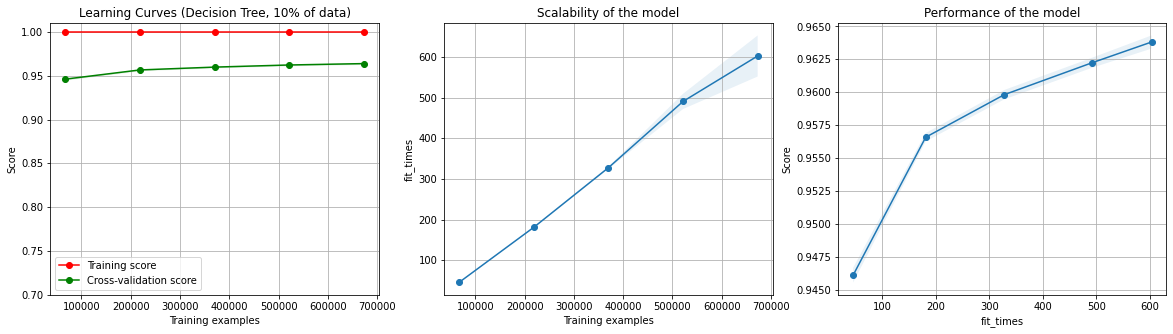

In [ ]:
title = r"Learning Curves (Decision Tree, 10% of data)"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

#### only 1% of dataset

In [ ]:
X = X[::10, :]
y = y[::10]

In [ ]:
X.shape

(84101, 186)

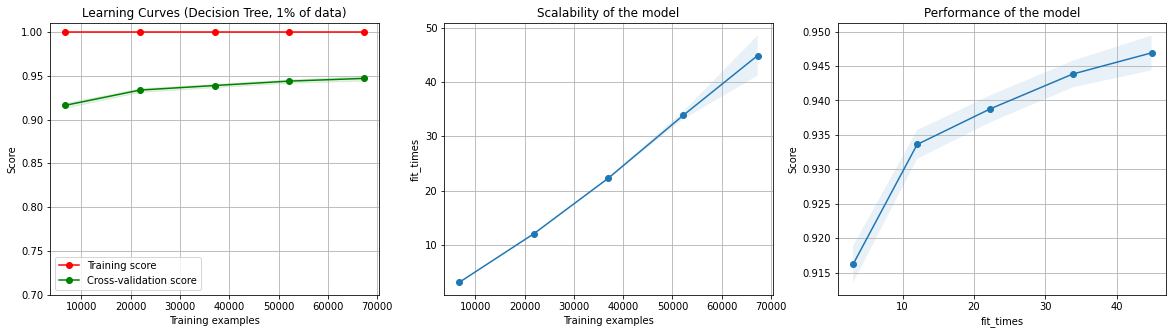

In [ ]:
title = r"Learning Curves (Decision Tree, 1% of data)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

#### only 0.1% of data

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(8411, 186)

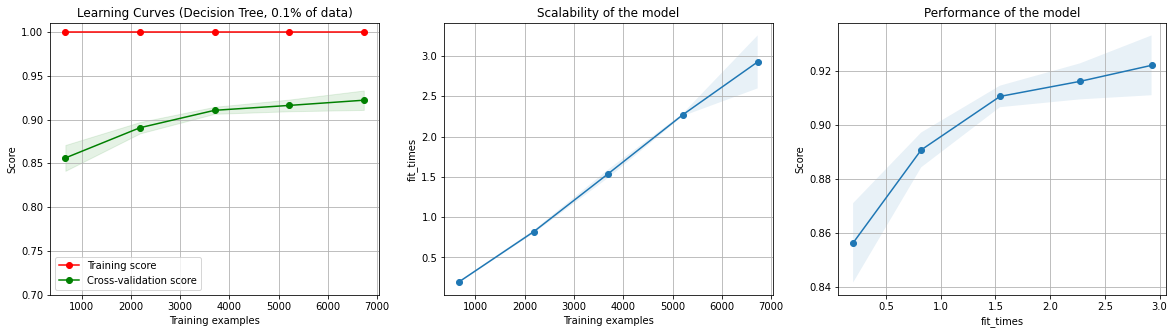

In [ ]:
title = r"Learning Curves (Decision Tree, 0.1% of data)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(criterion='entropy')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

## load data 

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')
X.shape

(841005, 186)

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

## Embedded method (Random Forest)

#### select best hyperparameters

In [ ]:
param_grid = [{
              'n_estimators': [50, 100, 200],
              'criterion': ['gini', 'entropy'], 
              # 'max_depth': [3, 10, 'None'],
              # # 'min_samples_split': [2, 6], 
              # # 'min_samples_leaf': [1, 3],
              # 'max_features': ['auto', 'None'],
              # 'bootstrap': [True, False],
               }]

In [ ]:
clf = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator = clf,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1,
                           verbose=2)
grid_search = grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 53.7min finished


In [ ]:
best_estimator = grid_search.best_estimator_
best_estimator

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
best_score = grid_search.best_score_
best_score

0.9245668001346768

In [ ]:
grid_search.best_params_

{'criterion': 'entropy', 'n_estimators': 200}

In [ ]:
df1 = pd.DataFrame(grid_search.cv_results_)
df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,74.446001,0.749460,0.219654,0.005363,gini,50,"{'criterion': 'gini', 'n_estimators': 50}",0.930504,0.862842,0.948395,0.957788,0.899643,0.919834,0.034716,6
1,149.260389,0.809488,0.432315,0.026821,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.931336,0.861831,0.949822,0.959869,0.906064,0.921784,0.035126,5
2,296.259738,3.761459,0.852481,0.019177,gini,200,"{'criterion': 'gini', 'n_estimators': 200}",0.932287,0.863258,0.951962,0.960583,0.905529,0.922724,0.035246,3
3,106.955155,1.824508,0.209983,0.009929,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.929731,0.867658,0.949168,0.959631,0.905054,0.922248,0.033027,4
4,212.746082,3.212575,0.391383,0.016817,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.930860,0.865874,0.953924,0.961058,0.906837,0.923711,0.034608,2
5,404.013603,41.212240,0.757023,0.079088,entropy,200,"{'criterion': 'entropy', 'n_estimators': 200}",0.932109,0.866944,0.954043,0.961950,0.907788,0.924567,0.034424,1


"100 number of estimators" seems reasonable since by doubling number of estimators, fit time will be almost doubled.
"entropy" seems to work better than gini however its taking a bit more time for fitting 

In [ ]:
param_grid = [{
              'max_depth': [3, 10, 20],
              'min_samples_split': [2, 4, 6], 
              # # 'min_samples_leaf': [1, 3],
              # 'max_features': ['auto', 'None'],
              # 'bootstrap': [True, False],
               }]

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')

In [ ]:
grid_search = GridSearchCV(estimator = clf,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1,
                           verbose=1)
grid_search = grid_search.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 59.8min finished


In [ ]:
best_estimator = grid_search.best_estimator_
best_estimator

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
best_score = grid_search.best_score_
best_score

0.9233658644377558

In [ ]:
grid_search.best_params_

{'max_depth': 20, 'min_samples_split': 2}

In [ ]:
df2 = pd.DataFrame(grid_search.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,71.478421,0.511285,0.254902,0.026831,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.813091,0.717895,0.728419,0.759810,0.755589,0.754961,0.033110,9
1,71.268983,0.295228,0.228459,0.022505,3,4,"{'max_depth': 3, 'min_samples_split': 4}",0.818322,0.713377,0.730678,0.763377,0.758205,0.756792,0.035772,8
2,70.641408,0.459521,0.218079,0.011570,3,6,"{'max_depth': 3, 'min_samples_split': 6}",0.823435,0.726576,0.733234,0.762426,0.762010,0.761536,0.034222,7
3,189.453496,0.565108,0.353733,0.014172,10,2,"{'max_depth': 10, 'min_samples_split': 2}",0.937162,0.848633,0.931451,0.941617,0.869263,0.905625,0.038800,5
4,189.961129,0.481921,0.366377,0.015534,10,4,"{'max_depth': 10, 'min_samples_split': 4}",0.939243,0.848454,0.930975,0.940190,0.870809,0.905934,0.038595,4
5,188.428776,0.820417,0.365925,0.012964,10,6,"{'max_depth': 10, 'min_samples_split': 6}",0.935795,0.846433,0.927824,0.938704,0.870749,0.903901,0.037954,6
6,213.524940,2.487702,0.415579,0.006181,20,2,"{'max_depth': 20, 'min_samples_split': 2}",0.930801,0.865398,0.953270,0.961950,0.905410,0.923366,0.034988,1
7,212.892871,2.807153,0.403070,0.012679,20,4,"{'max_depth': 20, 'min_samples_split': 4}",0.930622,0.864447,0.951902,0.960761,0.906540,0.922855,0.034695,3
8,209.183002,12.026209,0.402758,0.047303,20,6,"{'max_depth': 20, 'min_samples_split': 6}",0.931098,0.865042,0.951724,0.962782,0.906183,0.923366,0.034970,2
9,0.122288,0.003883,0.000000,0.000000,None,2,"{'max_depth': 'None', 'min_samples_split': 2}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [ ]:
param_grid = [{
              'max_depth': [20, None], 
              'min_samples_leaf': [1, 3],
              # 'max_features': ['auto', None],
              # 'bootstrap': [True, False],
               }]

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=2)

In [ ]:
grid_search = GridSearchCV(estimator = clf,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1,
                           verbose=1)
grid_search = grid_search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 35.0min finished


In [ ]:
best_estimator = grid_search.best_estimator_
best_estimator

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
best_score = grid_search.best_score_
best_score

0.9233301749462285

In [ ]:
grid_search.best_params_

{'max_depth': 20, 'min_samples_leaf': 1}

In [ ]:
df3 = pd.DataFrame(grid_search.cv_results_)
df3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,210.695540,3.552734,0.375426,0.017144,20,1,"{'max_depth': 20, 'min_samples_leaf': 1}",0.932287,0.865815,0.952913,0.962307,0.903329,0.923330,0.035164,1
1,206.988252,3.917355,0.365673,0.014244,20,3,"{'max_depth': 20, 'min_samples_leaf': 3}",0.931336,0.864031,0.951249,0.963199,0.904518,0.922866,0.035503,3
2,212.542900,2.908950,0.369355,0.012532,None,1,"{'max_depth': None, 'min_samples_leaf': 1}",0.929790,0.865933,0.952438,0.960226,0.905648,0.922807,0.034223,4
3,205.240600,3.433269,0.343821,0.030774,None,3,"{'max_depth': None, 'min_samples_leaf': 3}",0.932346,0.863793,0.952854,0.961653,0.905054,0.923140,0.035497,2


#### Build Model

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracy = np.array([])
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=100,
                                 criterion='entropy', 
                                 min_samples_split=2,
                                 max_depth=20,
                                 min_samples_leaf=1).fit(X_train, y_train)
                                 
    predict = clf.predict(X_test)
    acc = accuracy_score(y_test, predict)
    accuracy = np.append(accuracy, acc)

In [ ]:
accuracy.mean()

0.9711061706528581

No handles with labels found to put in legend.


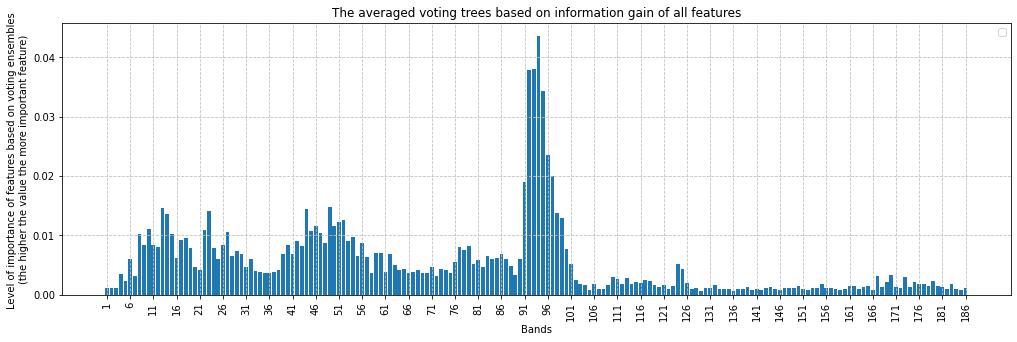

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(np.arange(186) + 1, clf.feature_importances_)
plt.xlabel('Bands')
plt.ylabel('Level of importance of features based on voting ensembles \n(the higher the value the more important feature)')
plt.title('The averaged voting trees based on information gain of all features')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.legend(loc="best")
# plt.savefig('/content/drive/MyDrive/Thesis/images/normalized/no_background/LR/' + 'ttest_normalized' + '.png')
plt.show() 

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
ordered_bands = pd.DataFrame()

In [ ]:
ordered_bands.insert(loc=ordered_bands.shape[1], column='steps', value=np.arange(186)+1)
ordered_bands.insert(loc=ordered_bands.shape[1], column='band_list', value=columns)
ordered_bands.insert(loc=ordered_bands.shape[1], column='importance', value=clf.feature_importances_)

In [ ]:
ordered_bands.sort_values(by=['importance'], inplace=True, ascending=False)

In [ ]:
ordered_bands.to_csv('/content/drive/MyDrive/Thesis/results/embedded/ordered_list_RandomForest.csv')
ordered_bands.head(10)

,steps,band_list,importance
93,94,Band_094,0.043609
92,93,Band_093,0.038026
91,92,Band_092,0.037785
94,95,Band_095,0.034317
95,96,Band_096,0.023609
96,97,Band_097,0.020000
90,91,Band_091,0.018932
48,49,Band_049,0.014807
12,13,Band_013,0.014667
43,44,Band_044,0.014379


## learning curves

### RF on embedded method (random forest)

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')
X.shape

(841005, 186)

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

In [ ]:
ordered_bands = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/ordered_list_RandomForest.csv')
ordered_bands.head(3)

,Unnamed: 0,steps,band_list,importance
0,93,94,Band_094,0.039478
1,94,95,Band_095,0.039350
2,92,93,Band_093,0.035638


In [ ]:
bands_list = ordered_bands.band_list.values

In [ ]:
# get columns names
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
df = pd.DataFrame(data=X, columns=columns)
df.head(3)

,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,Band_039,Band_040,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
0,0.055364,0.071277,0.062560,0.062931,0.073905,0.055737,0.062921,0.060123,0.056552,0.062749,0.059414,0.059066,0.066134,0.064663,0.062497,0.063313,0.062573,0.063923,0.072067,0.061628,0.068952,0.069534,0.063854,0.063532,0.063523,0.063333,0.066438,0.065995,0.068486,0.067091,0.065591,0.069869,0.071611,0.071547,0.075075,0.079294,0.077710,0.074765,0.081016,0.080989,...,0.256003,0.244539,0.252226,0.255288,0.258960,0.255068,0.257223,0.266414,0.260323,0.269098,0.268707,0.262175,0.269845,0.263428,0.276127,0.277523,0.279097,0.271806,0.286093,0.284609,0.276917,0.290901,0.271737,0.296084,0.287388,0.288105,0.297305,0.287817,0.293130,0.280577,0.294222,0.307158,0.299976,0.291312,0.304959,0.295205,0.289494,0.300307,0.298140,0.306262
1,0.074993,0.072435,0.064133,0.080734,0.088216,0.070953,0.067431,0.068336,0.079696,0.081326,0.072144,0.064534,0.071140,0.076132,0.076926,0.073100,0.068827,0.075382,0.074642,0.074307,0.076571,0.078271,0.073199,0.074093,0.081167,0.073853,0.073868,0.075267,0.083201,0.082551,0.086952,0.093180,0.105580,0.112416,0.123468,0.129664,0.151454,0.161905,0.169379,0.175393,...,0.505026,0.494720,0.483715,0.488838,0.488722,0.487259,0.482478,0.480058,0.500768,0.489220,0.471241,0.482861,0.477204,0.484921,0.481572,0.477932,0.482379,0.469481,0.480970,0.455296,0.474330,0.453260,0.479589,0.466238,0.457954,0.463635,0.447302,0.468616,0.465824,0.460319,0.453349,0.457308,0.448119,0.459175,0.454227,0.460216,0.452923,0.471841,0.476259,0.469941
2,0.045479,0.042046,0.037275,0.043536,0.034465,0.042052,0.041346,0.036096,0.037316,0.034090,0.038630,0.037338,0.038530,0.039467,0.037237,0.036758,0.041296,0.038946,0.038131,0.033877,0.036581,0.036654,0.043430,0.040508,0.038260,0.039300,0.039091,0.035584,0.043376,0.038516,0.041190,0.044052,0.045166,0.049253,0.055280,0.056265,0.060899,0.063739,0.068785,0.068890,...,0.180802,0.178378,0.176781,0.181192,0.180998,0.177616,0.173728,0.184667,0.180696,0.179134,0.180556,0.175598,0.176941,0.179723,0.179929,0.182357,0.179584,0.178325,0.181278,0.178470,0.181702,0.175787,0.171325,0.178576,0.181164,0.177727,0.170604,0.175006,0.180909,0.169396,0.169240,0.168891,0.165199,0.170660,0.173753,0.182452,0.168766,0.164232,0.174707,0.171867


In [ ]:
X = np.zeros((df.shape), dtype='float32')

In [ ]:
for i in range(186):
  X[:, i:i+1] = np.array(df[bands_list[i]].values.reshape(-1, 1), dtype='float32')

#### fit

In [ ]:
%%time

num_of_folds = 5
# kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

# X = np.array(df[bands_list[0]].values.reshape(-1, 1), dtype='float32')
# y = np.array(y, dtype='int')

train_scores_mean_arr = np.array([])
train_scores_std_arr = np.array([])
val_scores_mean_arr = np.array([])
val_scores_std_arr = np.array([])

train_scores = np.array([])
val_scores = np.array([])


for i in range(0, 186):

  # instantiate cross_validation instance
  kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=42)

  train_scores = np.array([])
  val_scores = np.array([])

  for train_index, val_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[:, 0:i+1][train_index], X[:, 0:i+1][val_index]
    y_train, y_val = y[train_index], y[val_index]

    # clf = random forest
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=50, criterion='entropy',)
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)

    train_scores = np.append(train_scores, train_score)
    val_scores = np.append(val_scores, val_score)

  train_scores_mean = np.mean(train_scores)
  train_scores_std = np.std(train_scores)
  val_scores_mean = np.mean(val_scores)
  val_scores_std = np.std(val_scores)

  train_scores_mean_arr = np.append(train_scores_mean_arr, train_scores_mean)
  train_scores_std_arr = np.append(train_scores_std_arr, train_scores_std)
  val_scores_mean_arr = np.append(val_scores_mean_arr, val_scores_mean)
  val_scores_std_arr = np.append(val_scores_std_arr, val_scores_std)

  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
CPU times: user 18h 19min 22s, sys: 1min 49s, total: 18h 21min 11s
Wall time: 9h 26min 12s


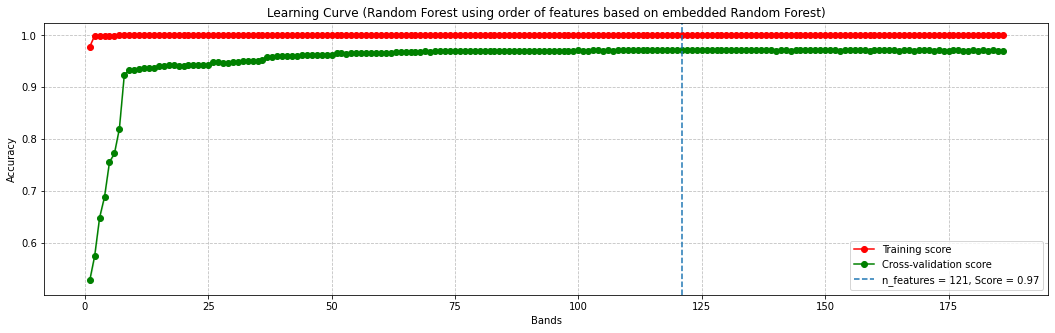

In [ ]:
steps = np.arange(186) + 1
plt.figure(figsize=(18, 5))
plt.fill_between(steps, train_scores_mean_arr - train_scores_std_arr,
                 train_scores_mean_arr + train_scores_std_arr, alpha=0.1, color="r")
plt.fill_between(steps, val_scores_mean_arr - val_scores_std_arr,
                 val_scores_mean_arr + val_scores_std_arr, alpha=0.1, color="g")
plt.plot(steps, train_scores_mean_arr, 'o-', color="r", label="Training score")
plt.plot(steps, val_scores_mean_arr, 'o-', color="g", label="Cross-validation score")
plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Random Forest using order of features based on embedded Random Forest)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

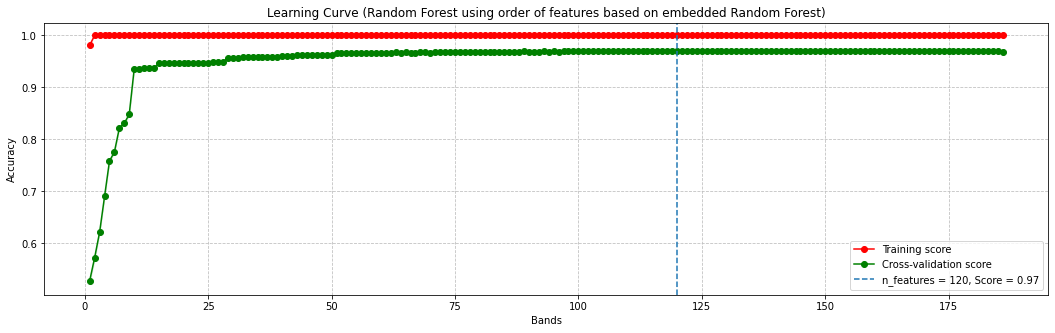

In [ ]:
steps = np.arange(186) + 1
plt.figure(figsize=(18, 5))
plt.fill_between(steps, train_scores_mean_arr - train_scores_std_arr,
                 train_scores_mean_arr + train_scores_std_arr, alpha=0.1, color="r")
plt.fill_between(steps, val_scores_mean_arr - val_scores_std_arr,
                 val_scores_mean_arr + val_scores_std_arr, alpha=0.1, color="g")
plt.plot(steps, train_scores_mean_arr, 'o-', color="r", label="Training score")
plt.plot(steps, val_scores_mean_arr, 'o-', color="g", label="Cross-validation score")
plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Random Forest using order of features based on embedded Random Forest)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
steps = np.arange(186) + 1
df = pd.DataFrame(data=steps, columns=['steps'])
df.insert(loc=1, column='ordered_bands', value=bands_list[0:186], allow_duplicates=True)
df.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)

In [ ]:
# save learning curve into a csv file
df.to_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_RandomForest_RF.csv')

In [ ]:
# read learning curve tabel from the csv file
df = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_RandomForest_RF.csv')
df = df.iloc[:, 1:]
df.tail()

,steps,ordered_bands,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
181,182,Band_159,0.999985,8.836527e-11,0.970892,0.001764
182,183,Band_166,0.999982,1.733313e-05,0.970524,0.002448
183,184,Band_142,0.999988,1.112249e-05,0.970856,0.001929
184,185,Band_136,0.999976,1.515742e-05,0.970405,0.001717
185,186,Band_129,0.999988,1.456274e-05,0.970464,0.001801


### all in one

In [ ]:
df_lr = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_RandomForest_LR.csv')
df_rf = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_RandomForest_RF.csv')
df_svm = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_RandomForest_SVM.csv')

In [ ]:
lr_train_scores_mean_arr = df_lr.train_scores_mean.values
lr_train_scores_std_arr = df_lr.train_scores_std.values
lr_val_scores_mean_arr = df_lr.val_scores_mean.values
lr_val_scores_std_arr = df_lr.val_scores_std.values

rf_train_scores_mean_arr = df_rf.train_scores_mean.values
rf_train_scores_std_arr = df_rf.train_scores_std.values
rf_val_scores_mean_arr = df_rf.val_scores_mean.values
rf_val_scores_std_arr = df_rf.val_scores_std.values

svm_train_scores_mean_arr = df_svm.train_scores_mean.values
svm_train_scores_std_arr = df_svm.train_scores_std.values
svm_val_scores_mean_arr = df_svm.val_scores_mean.values
svm_val_scores_std_arr = df_svm.val_scores_std.values

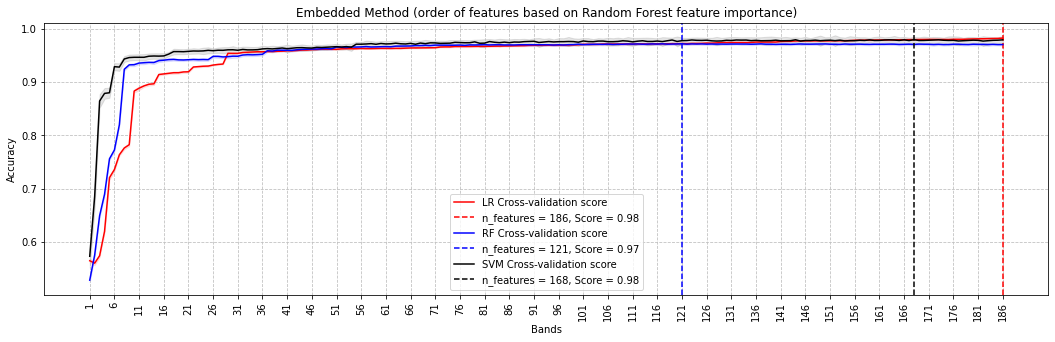

In [ ]:
steps_lr = np.arange(len(lr_train_scores_mean_arr)) + 1
steps_rf = np.arange(len(rf_train_scores_mean_arr)) + 1
# steps_svm = np.arange(len(svm_train_scores_mean_arr)) + 1
steps_svm = np.arange(len(svm_train_scores_mean_arr)) + 1

plt.figure(figsize=(18, 5))

# logistic regression
# plt.fill_between(steps_lr, lr_train_scores_mean_arr - lr_train_scores_std_arr,
#                  lr_train_scores_mean_arr + lr_train_scores_std_arr, alpha=0.1, color="green")
plt.fill_between(steps_lr, lr_val_scores_mean_arr - lr_val_scores_std_arr,
                 lr_val_scores_mean_arr + lr_val_scores_std_arr, alpha=0.1, color="red")
# plt.plot(steps_lr, lr_train_scores_mean_arr, '--', color="green", label="LR Training score")
plt.plot(steps_lr, lr_val_scores_mean_arr, '-', color="red", label="LR Cross-validation score")
plt.axvline(x=lr_val_scores_mean_arr.argmax() + 1, color="red", ls='--', label='n_features = {}, Score = {}'.format(lr_val_scores_mean_arr.argmax()+1, round(lr_val_scores_mean_arr.max(), 2)))

# random forest
# plt.fill_between(steps_rf, rf_train_scores_mean_arr - rf_train_scores_std_arr,
#                  rf_train_scores_mean_arr + rf_train_scores_std_arr, alpha=0.1, color="blue")
plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
                 rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="blue")
# plt.plot(steps_rf, rf_train_scores_mean_arr, '--', color="blue", label="RF Training score")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="blue", label="RF Cross-validation score")
plt.axvline(x=rf_val_scores_mean_arr.argmax() + 1, color="blue", ls='--', label='n_features = {}, Score = {}'.format(rf_val_scores_mean_arr.argmax()+1, round(rf_val_scores_mean_arr.max(), 2)))

# # svm
# plt.fill_between(steps_svm, svm_train_scores_mean_arr - svm_train_scores_std_arr,
#                  svm_train_scores_mean_arr + svm_train_scores_std_arr, alpha=0.1, color="orange")
# plt.fill_between(steps_svm, svm_val_scores_mean_arr - svm_val_scores_std_arr,
#                  svm_val_scores_mean_arr + svm_val_scores_std_arr, alpha=0.1, color="gray")
# plt.plot(steps_svm, svm_train_scores_mean_arr, '--', color="orange", label="SVM Training score")
# plt.plot(steps_svm, svm_val_scores_mean_arr, '-', color="gray", label="SVM Cross-validation score")
# plt.axvline(x=svm_val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr.argmax()+1, round(svm_val_scores_mean_arr.max(), 2)))

# svm
# plt.fill_between(steps_svm2, svm_train_scores_mean_arr2 - svm_train_scores_std_arr2,
#                  svm_train_scores_mean_arr2 + svm_train_scores_std_arr2, alpha=0.1, color="Magenta")
plt.fill_between(steps_svm, svm_val_scores_mean_arr - svm_val_scores_std_arr,
                 svm_val_scores_mean_arr + svm_val_scores_std_arr, alpha=0.1, color="black")
# plt.plot(steps_svm2, svm_train_scores_mean_arr2, '--', color="Magenta", label="SVM SGD classifier Training score")
plt.plot(steps_svm, svm_val_scores_mean_arr, '-', color="black", label="SVM Cross-validation score")
plt.axvline(x=svm_val_scores_mean_arr.argmax() + 1, color="black", ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr.argmax()+1, round(svm_val_scores_mean_arr.max(), 2)))

plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Embedded Method (order of features based on Random Forest feature importance)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

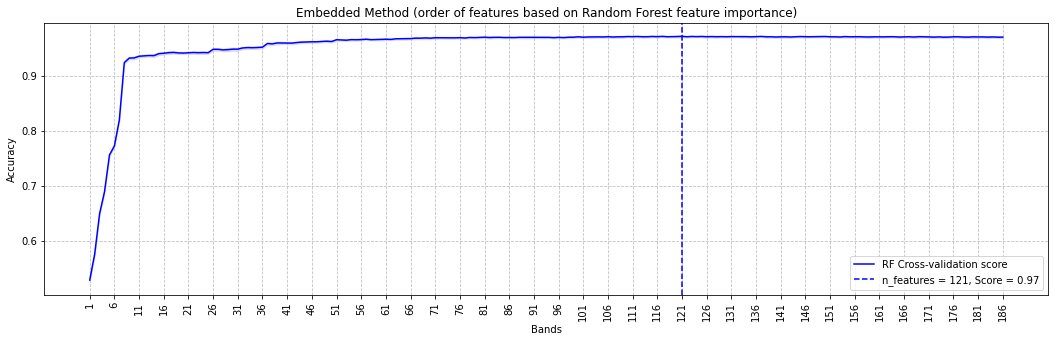

In [ ]:
steps_rf = np.arange(len(rf_train_scores_mean_arr)) + 1

plt.figure(figsize=(18, 5))

# random forest
# plt.fill_between(steps_rf, rf_train_scores_mean_arr - rf_train_scores_std_arr,
#                  rf_train_scores_mean_arr + rf_train_scores_std_arr, alpha=0.1, color="blue")
plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
                 rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="blue")
# plt.plot(steps_rf, rf_train_scores_mean_arr, '--', color="blue", label="RF Training score")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="blue", label="RF Cross-validation score")
plt.axvline(x=rf_val_scores_mean_arr.argmax() + 1, color="blue", ls='--', label='n_features = {}, Score = {}'.format(rf_val_scores_mean_arr.argmax()+1, round(rf_val_scores_mean_arr.max(), 2)))

plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Embedded Method (order of features based on Random Forest feature importance)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


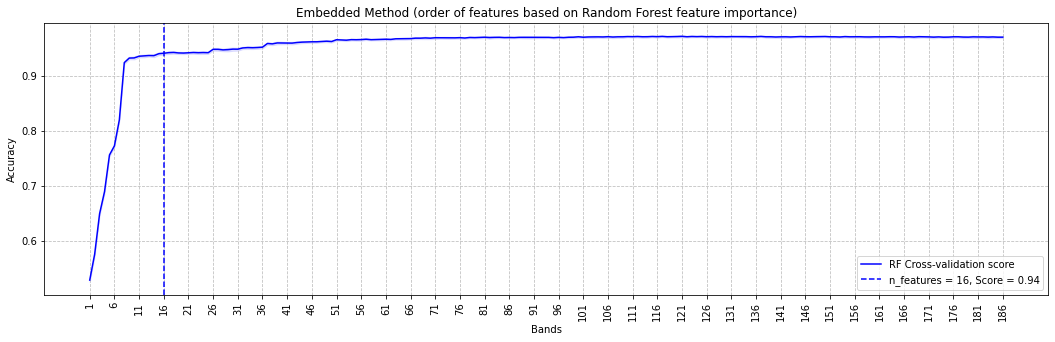

In [ ]:
stopping_critera = 0.002
steps_rf = np.arange(len(rf_train_scores_mean_arr)) + 1

plt.figure(figsize=(18, 5))

####################################### RF #######################################
plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
                 rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="blue")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="blue", label="RF Cross-validation score")
# plt.axvline(x=SBS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SBS_RF_avg_score.argmax()+1, str(round(SBS_RF_avg_score.max(), 2))))

# selected features based on new stopping criteria
RF_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_rf.val_scores_mean[i+9:i+10].values, df_rf.val_scores_mean[i:i+1].values) < stopping_critera:
    RF_filtered_features_index = np.append(RF_filtered_features_index, i)
RF_number_features = RF_filtered_features_index.min() + 1

plt.axvline(x=int(RF_number_features), ls='--', color="blue", label='n_features = {}, Score = {}'.format(int(RF_number_features), str(round(df_rf.val_scores_mean[int(RF_number_features)], 2))))


plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Embedded Method (order of features based on Random Forest feature importance)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
df_lr.head(3)

,Unnamed: 0,steps,ordered_bands,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
0,0,1,Band_094,0.564747,0.001057,0.564666,0.004031
1,1,2,Band_095,0.560311,0.000834,0.560112,0.003609
2,2,3,Band_093,0.574066,0.000810,0.574012,0.002977


In [ ]:
df = pd.DataFrame(data=np.zeros((186, 3)), columns=['LR', 'RF', 'SVM'])
df.iloc[:df_lr.val_scores_mean.argmax()+1,0:1] = np.arange(1, df_lr.val_scores_mean.argmax()+2).reshape((-1, 1))
df.iloc[:df_rf.val_scores_mean.argmax()+1,1:2] = np.arange(1, df_rf.val_scores_mean.argmax()+2).reshape((-1, 1))
df.iloc[:df_svm.val_scores_mean.argmax()+1,2:3] = np.arange(1, df_svm.val_scores_mean.argmax()+2).reshape((-1, 1))
df.insert(loc=0, column='features', value=df_lr.ordered_bands.values)
df.sort_values(by='features', inplace=True)
df.head()

,features,LR,RF,SVM
163,Band_001,164.0,0.0,164.0
161,Band_002,162.0,0.0,162.0
110,Band_003,111.0,111.0,111.0
73,Band_004,74.0,74.0,74.0
131,Band_005,132.0,0.0,132.0


In [ ]:
df.iloc[:, 1:] = np.abs(df.iloc[:, 1:] - 186)
df.loc[(df['LR'] == 186), 'LR'] = 0
df.loc[(df['RF'] == 186), 'RF'] = 0
df.loc[(df['SVM'] == 186), 'SVM'] = 0
df.head()

,features,LR,RF,SVM
163,Band_001,22.0,0.0,22.0
161,Band_002,24.0,0.0,24.0
110,Band_003,75.0,75.0,75.0
73,Band_004,112.0,112.0,112.0
131,Band_005,54.0,0.0,54.0


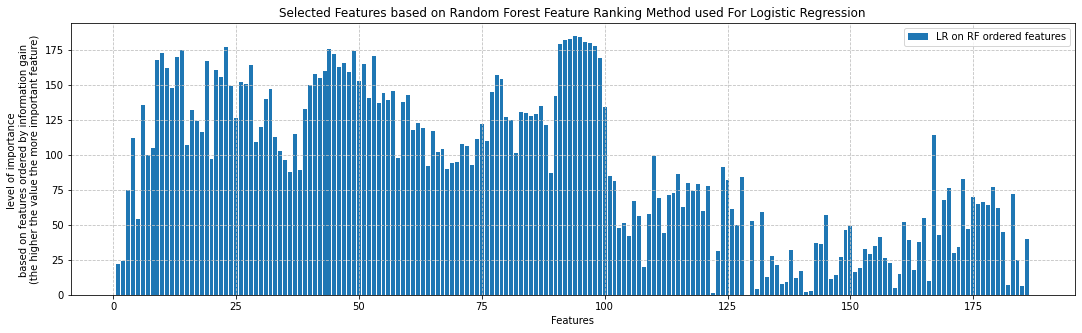

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.LR, label="LR on RF ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features based on Random Forest Feature Ranking Method used For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

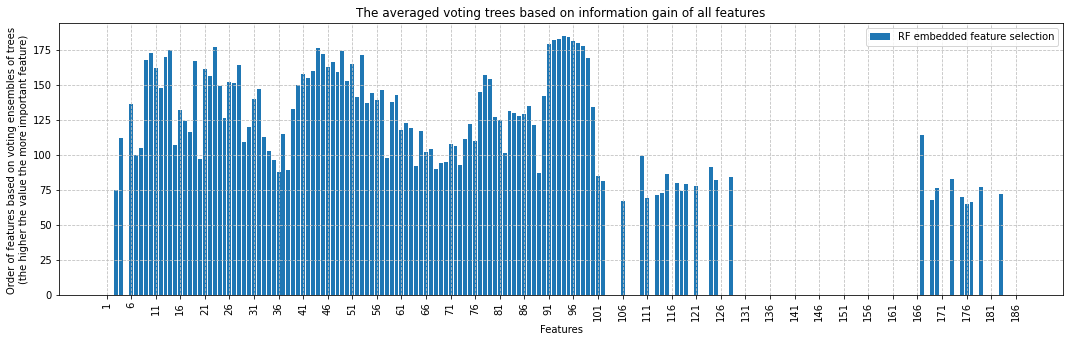

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.RF, label="RF embedded feature selection")
plt.xlabel('Features')
plt.ylabel('Order of features based on voting ensembles of trees \n(the higher the value the more important feature)')
plt.title('The averaged voting trees based on information gain of all features')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

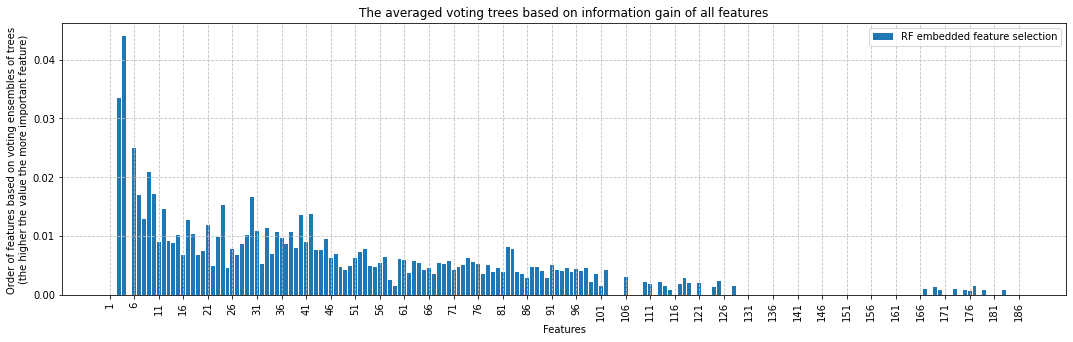

In [ ]:
rf_df = pd.DataFrame(data=df.RF.values, columns=['rf_order'])
rf_df.insert(loc=1, column='clf_measure', value=clf.feature_importances_)
rf_df.clf_measure[rf_df.rf_order==0] = 0

plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, rf_df.clf_measure, label="RF embedded feature selection")
plt.xlabel('Features')
plt.ylabel('Order of features based on voting ensembles of trees \n(the higher the value the more important feature)')
plt.title('The averaged voting trees based on information gain of all features')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

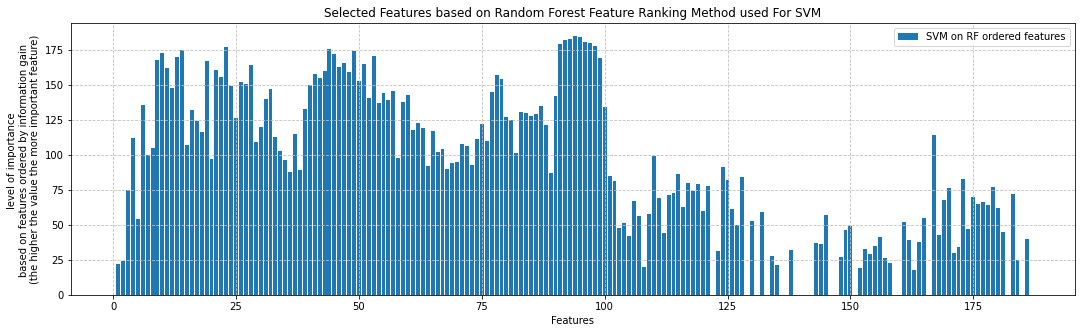

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SVM, label="SVM on RF ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features based on Random Forest Feature Ranking Method used For SVM')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
cf = pd.DataFrame(data=df.iloc[:,2:3].values, columns=['Highest Performance Stopping Criterai'])

In [ ]:
cf.insert(loc=1, column='Newly defined Stopping Critera', value=df.RF.values)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

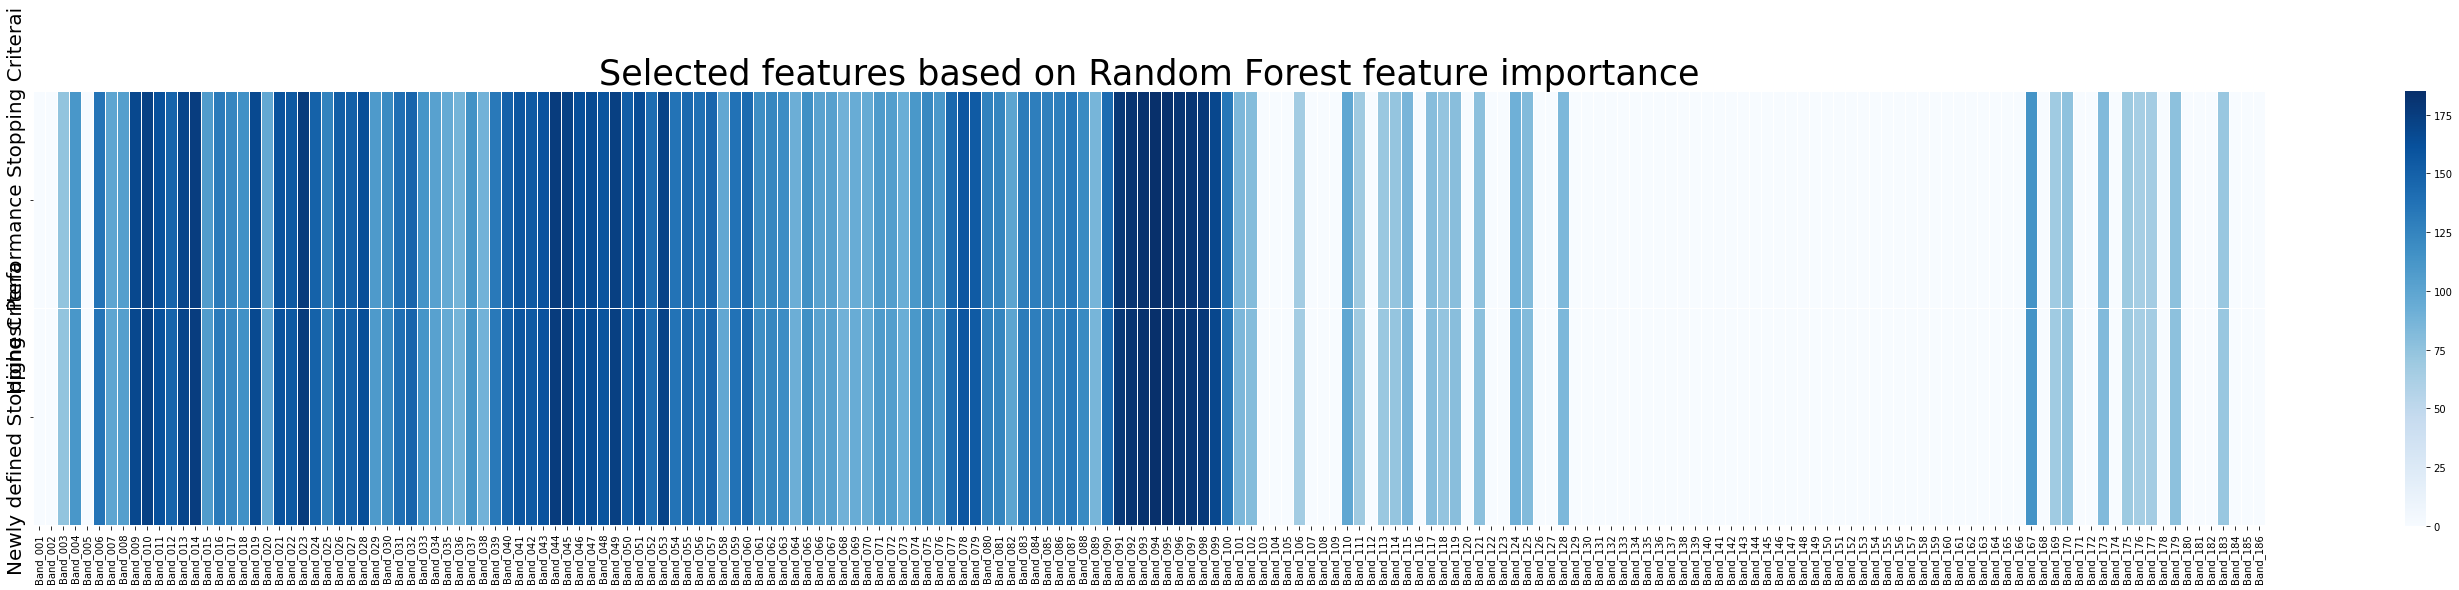

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(cf.iloc[:,:].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=cf.columns.values[:], ax=ax) #xticklabels=, 
plt.title('Selected features based on Random Forest feature importance', fontsize=35)
# plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
# plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.yticks(fontsize=20)

(array([0.5]), <a list of 1 Text major ticklabel objects>)

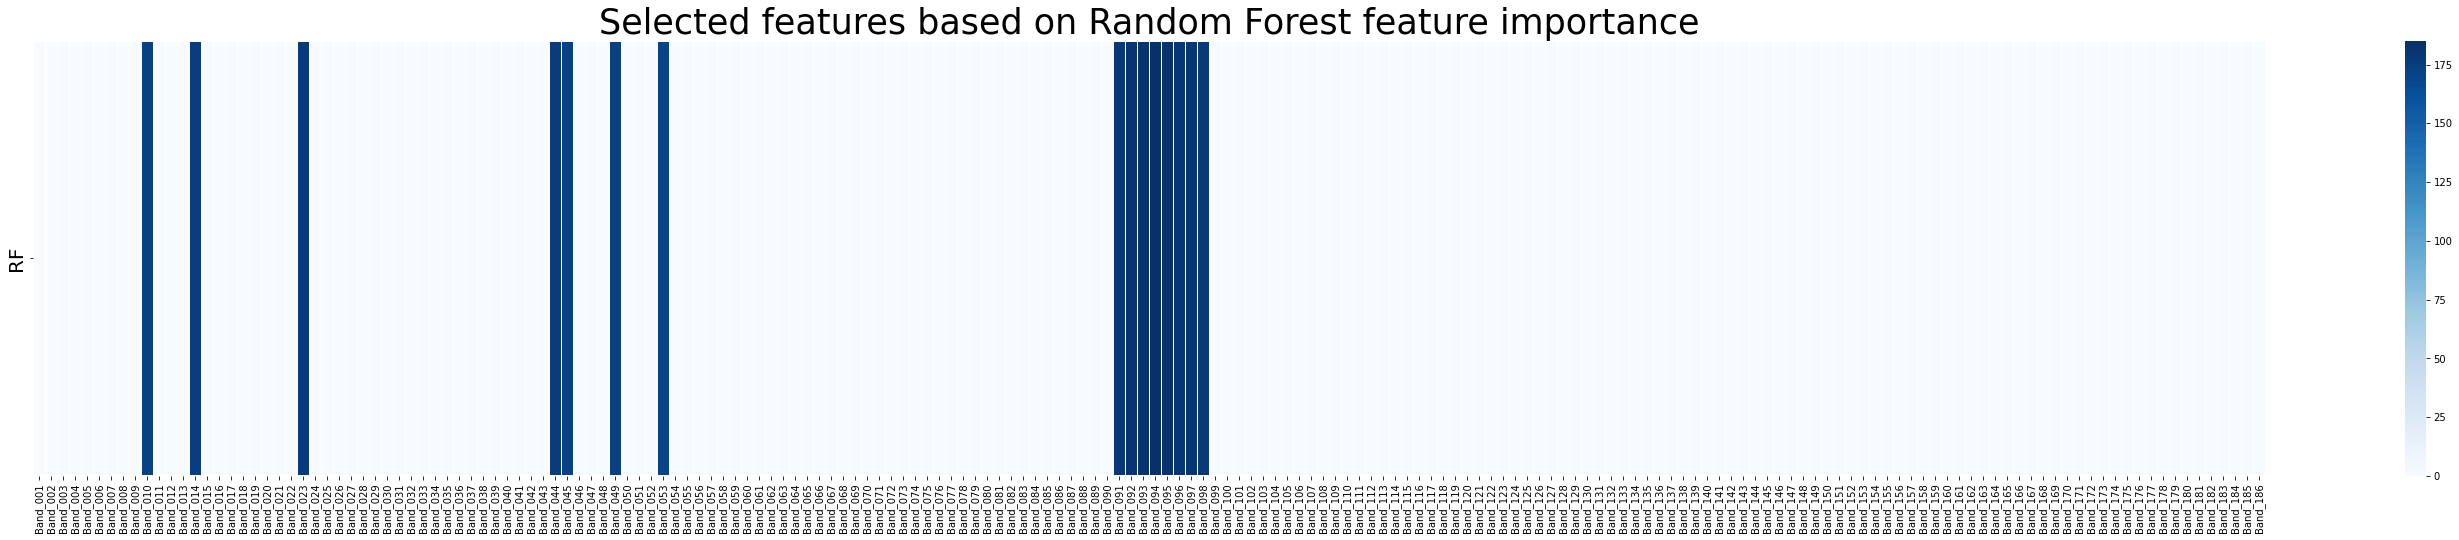

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,2:3].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[2:3], ax=ax) #xticklabels=, 
plt.title('Selected features based on Random Forest feature importance', fontsize=35)
# plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
# plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.yticks(fontsize=20)

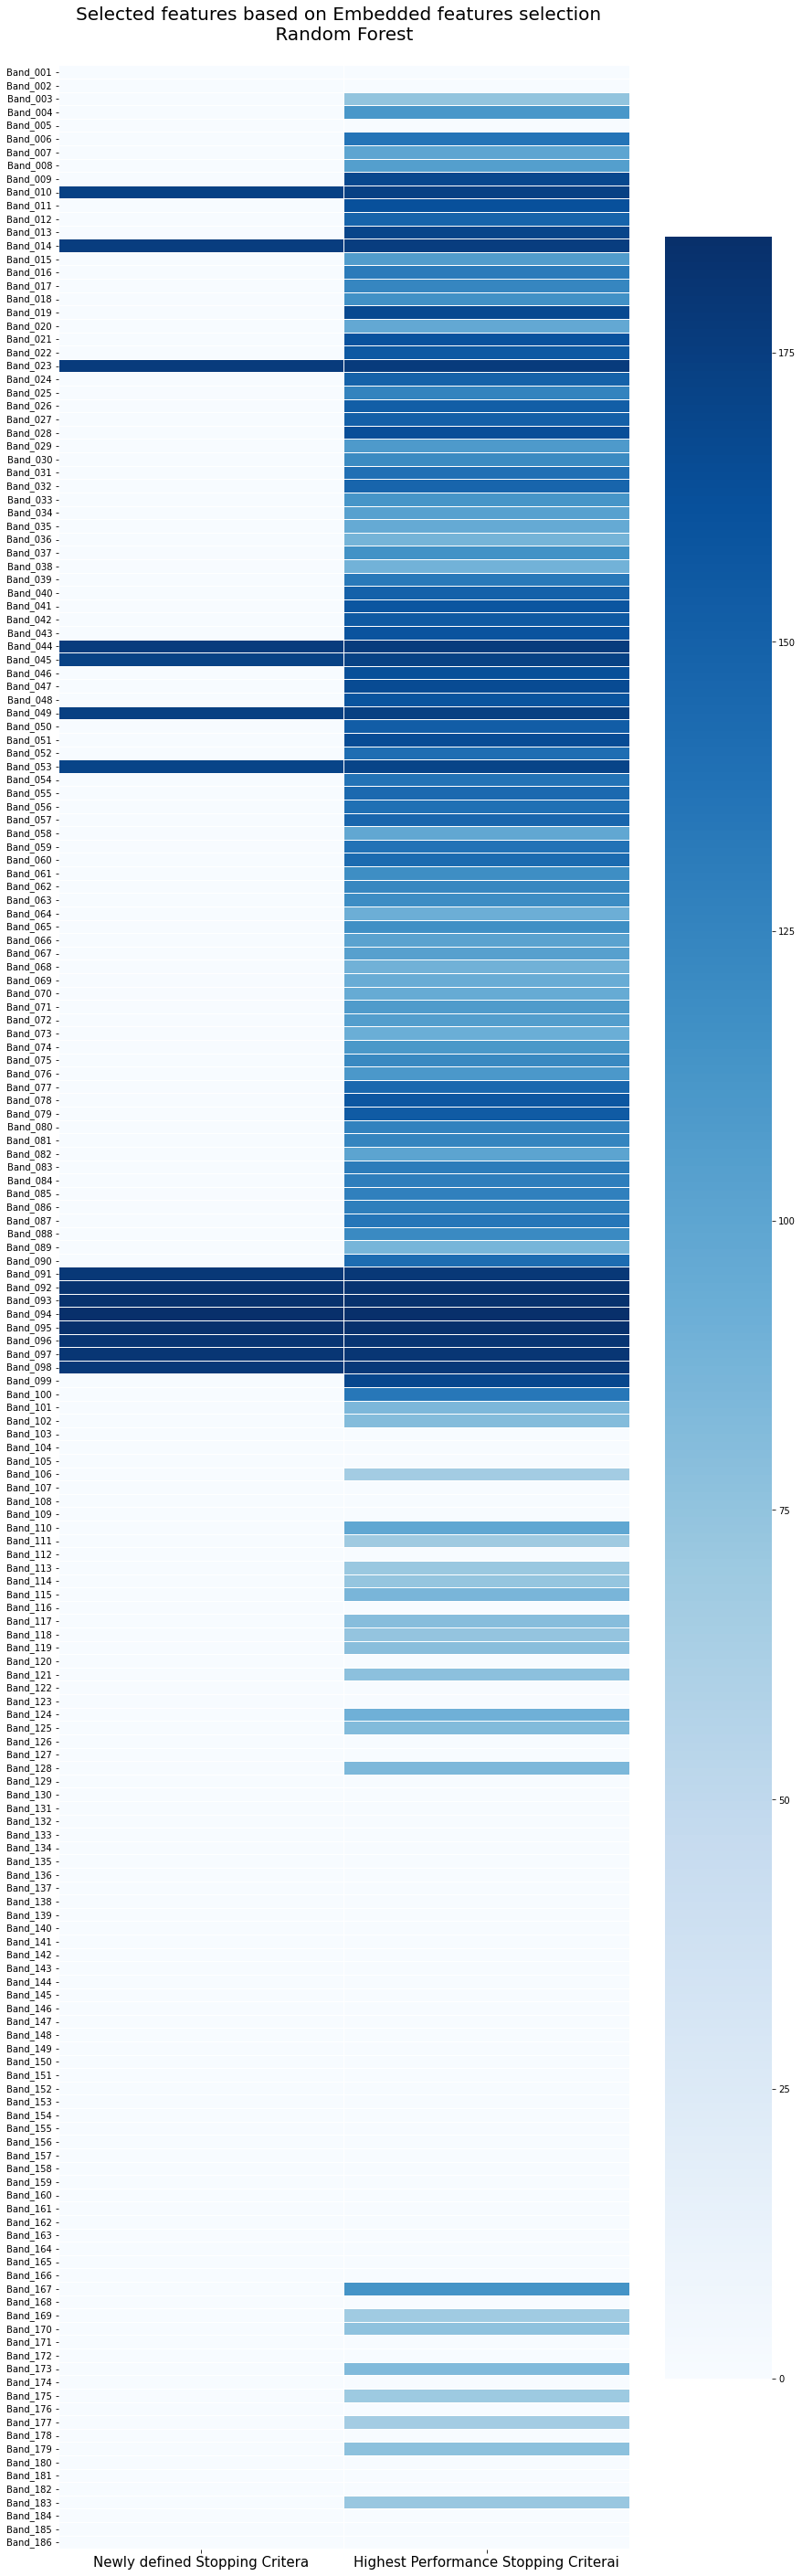

In [ ]:
fig, ax = plt.subplots(figsize=(14,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=cf.iloc[:,:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=['Newly defined Stopping Critera', 'Highest Performance Stopping Criterai'], ax=ax)

plt.title('Selected features based on Embedded features selection  \n Random Forest \n', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
# plt.yticks(fontsize=20)
plt.show()

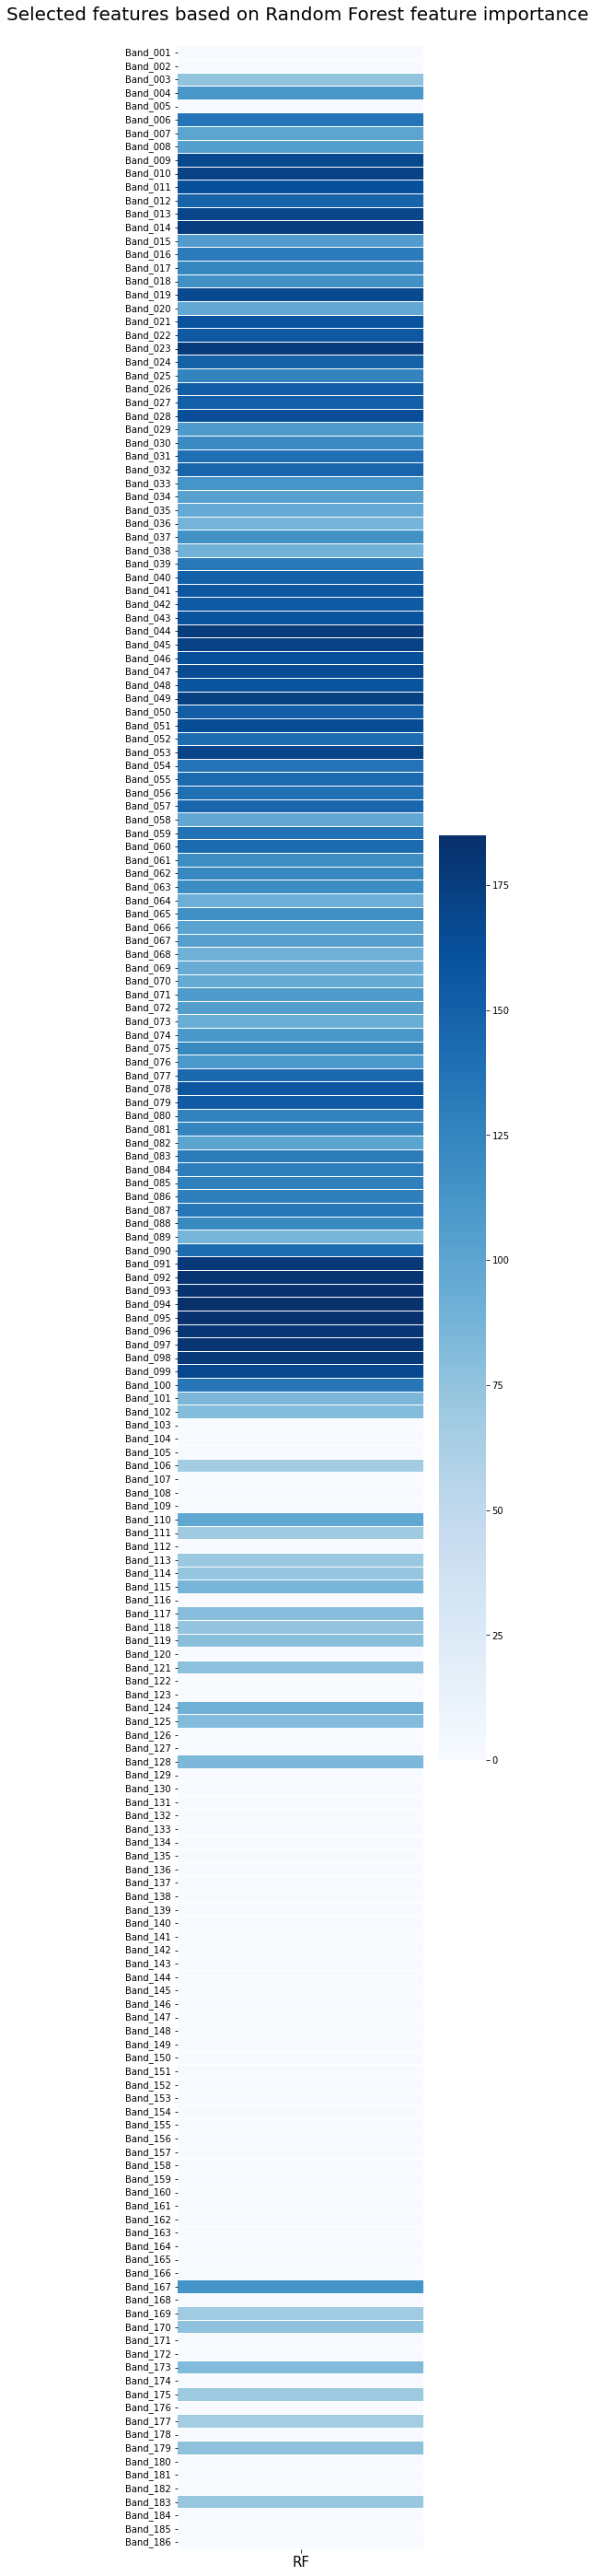

In [ ]:
fig, ax = plt.subplots(figsize=(6,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features based on Random Forest feature importance \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


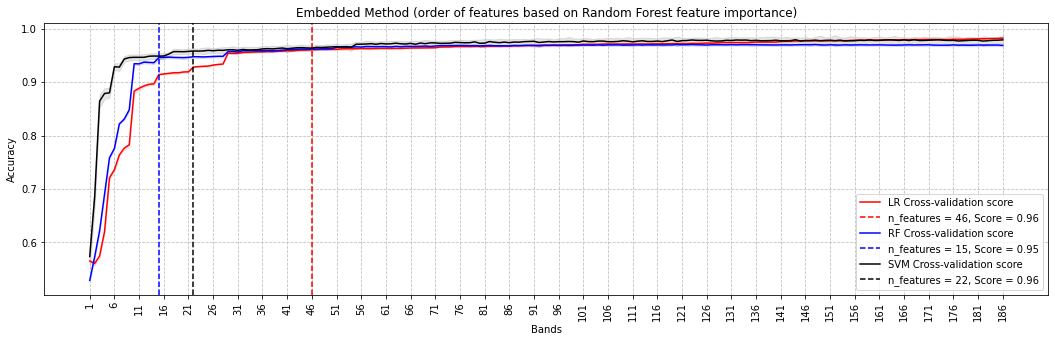

In [ ]:
stopping_critera = 0.002
steps_lr = np.arange(len(lr_train_scores_mean_arr)) + 1
steps_rf = np.arange(len(rf_train_scores_mean_arr)) + 1
steps_svm = np.arange(len(svm_train_scores_mean_arr)) + 1

plt.figure(figsize=(18, 5))

# ########################### logistic regression ########################### 
plt.fill_between(steps_lr, lr_val_scores_mean_arr - lr_val_scores_std_arr,
                 lr_val_scores_mean_arr + lr_val_scores_std_arr, alpha=0.1, color="red")
plt.plot(steps_lr, lr_val_scores_mean_arr, '-', color="red", label="LR Cross-validation score")
# plt.axvline(x=lr_val_scores_mean_arr.argmax() + 1, color="red", ls='--', label='n_features = {}, Score = {}'.format(lr_val_scores_mean_arr.argmax()+1, round(lr_val_scores_mean_arr.max(), 2)))

# selected features based on new stopping criteria
LR_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_lr.val_scores_mean[i+9:i+10].values, df_lr.val_scores_mean[i:i+1].values) < stopping_critera:
    LR_filtered_features_index = np.append(LR_filtered_features_index, i)
LR_number_features = LR_filtered_features_index.min() + 1

plt.axvline(x=int(LR_number_features), ls='--', color="red", label='n_features = {}, Score = {}'.format(int(LR_number_features), str(round(df_lr.val_scores_mean[int(LR_number_features)], 2))))

############################  random forest ##############################
plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
                 rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="blue")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="blue", label="RF Cross-validation score")
# plt.axvline(x=rf_val_scores_mean_arr.argmax() + 1, color="blue", ls='--', label='n_features = {}, Score = {}'.format(rf_val_scores_mean_arr.argmax()+1, round(rf_val_scores_mean_arr.max(), 2)))

# selected features based on new stopping criteria
RF_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_rf.val_scores_mean[i+9:i+10].values, df_rf.val_scores_mean[i:i+1].values) < stopping_critera:
    RF_filtered_features_index = np.append(RF_filtered_features_index, i)
RF_number_features = RF_filtered_features_index.min() + 1

plt.axvline(x=int(RF_number_features), ls='--', color="blue", label='n_features = {}, Score = {}'.format(int(RF_number_features), str(round(df_rf.val_scores_mean[int(RF_number_features)], 2))))


# ################################## svm ###################################
plt.fill_between(steps_svm, svm_val_scores_mean_arr - svm_val_scores_std_arr,
                 svm_val_scores_mean_arr + svm_val_scores_std_arr, alpha=0.1, color="black")
plt.plot(steps_svm, svm_val_scores_mean_arr, '-', color="black", label="SVM Cross-validation score")
# plt.axvline(x=svm_val_scores_mean_arr2.argmax() + 1, color="black", ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr2.argmax()+1, round(svm_val_scores_mean_arr2.max(), 2)))

# selected features based on new stopping criteria
SVM_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(df_svm.val_scores_mean[i+9:i+10].values, df_svm.val_scores_mean[i:i+1].values) < stopping_critera:
    SVM_filtered_features_index = np.append(SVM_filtered_features_index, i)
SVM_number_features = SVM_filtered_features_index.min() + 1

plt.axvline(x=int(SVM_number_features), ls='--', color="black", label='n_features = {}, Score = {}'.format(int(SVM_number_features), str(round(df_svm.val_scores_mean[int(SVM_number_features)], 2))))



plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Embedded Method (order of features based on Random Forest feature importance)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
df = pd.DataFrame(data=np.zeros((186, 3)), columns=['LR', 'RF', 'SVM'])
df.iloc[:int(LR_number_features), 0:1] = np.arange(1, int(LR_number_features)+1).reshape((-1, 1))
df.iloc[:int(RF_number_features),1:2] = np.arange(1, int(RF_number_features)+1).reshape((-1, 1))
df.iloc[:int(SVM_number_features),2:3] = np.arange(1, int(SVM_number_features)+1).reshape((-1, 1))
df.insert(loc=0, column='features', value=df_lr.ordered_bands.values)
df.sort_values(by='features', inplace=True)
df.head()

,features,LR,RF,SVM
163,Band_001,0.0,0.0,0.0
161,Band_002,0.0,0.0,0.0
110,Band_003,0.0,0.0,0.0
73,Band_004,0.0,0.0,0.0
131,Band_005,0.0,0.0,0.0


In [ ]:
df.iloc[:, 1:] = np.abs(df.iloc[:, 1:] - 186)
df.loc[(df['LR'] == 186), 'LR'] = 0
df.loc[(df['RF'] == 186), 'RF'] = 0
df.loc[(df['SVM'] == 186), 'SVM'] = 0
df.head()

,features,LR,RF,SVM
163,Band_001,0.0,0.0,0.0
161,Band_002,0.0,0.0,0.0
110,Band_003,0.0,0.0,0.0
73,Band_004,0.0,0.0,0.0
131,Band_005,0.0,0.0,0.0


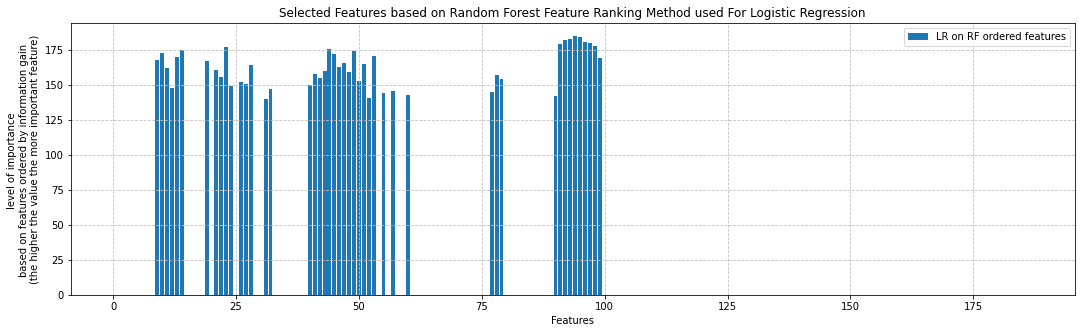

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.LR, label="LR on RF ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features based on Random Forest Feature Ranking Method used For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

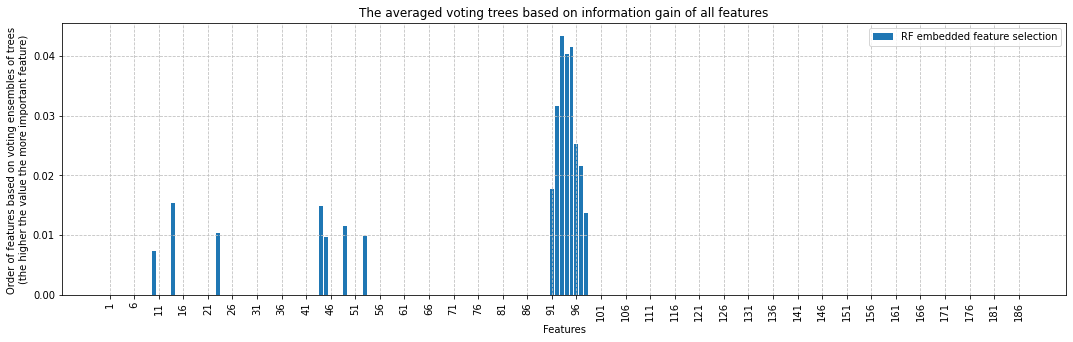

In [ ]:
rf_df = pd.DataFrame(data=df.RF.values, columns=['rf_order'])
rf_df.insert(loc=1, column='clf_measure', value=clf.feature_importances_)
rf_df.clf_measure[rf_df.rf_order==0] = 0

plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, rf_df.clf_measure, label="RF embedded feature selection")
plt.xlabel('Features')
plt.ylabel('Order of features based on voting ensembles of trees \n(the higher the value the more important feature)')
plt.title('The averaged voting trees based on information gain of all features')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

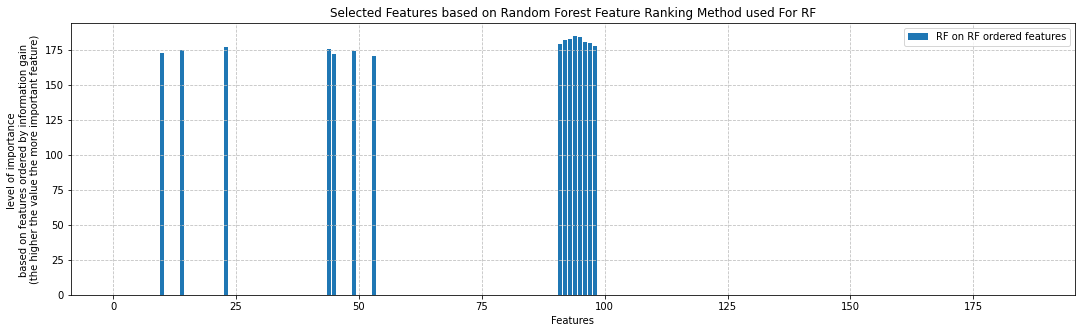

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.RF, label="RF on RF ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features based on Random Forest Feature Ranking Method used For RF')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

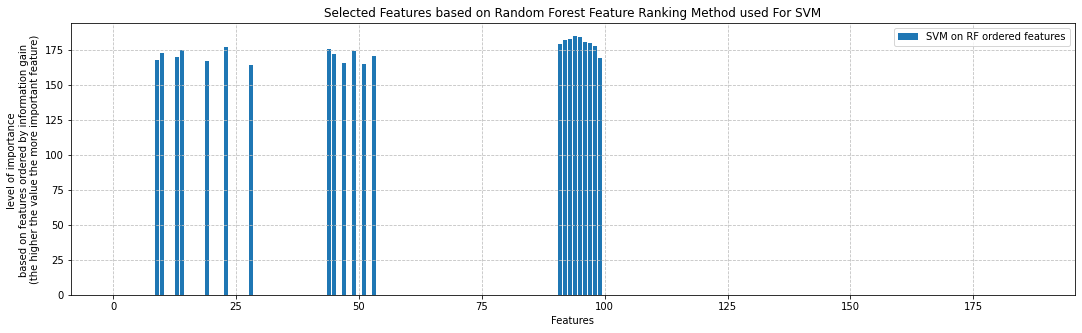

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SVM, label="SVM on RF ordered features")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on features ordered by information gain \n(the higher the value the more important feature)')
plt.title('Selected Features based on Random Forest Feature Ranking Method used For SVM')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

(array([0.5]), <a list of 1 Text major ticklabel objects>)

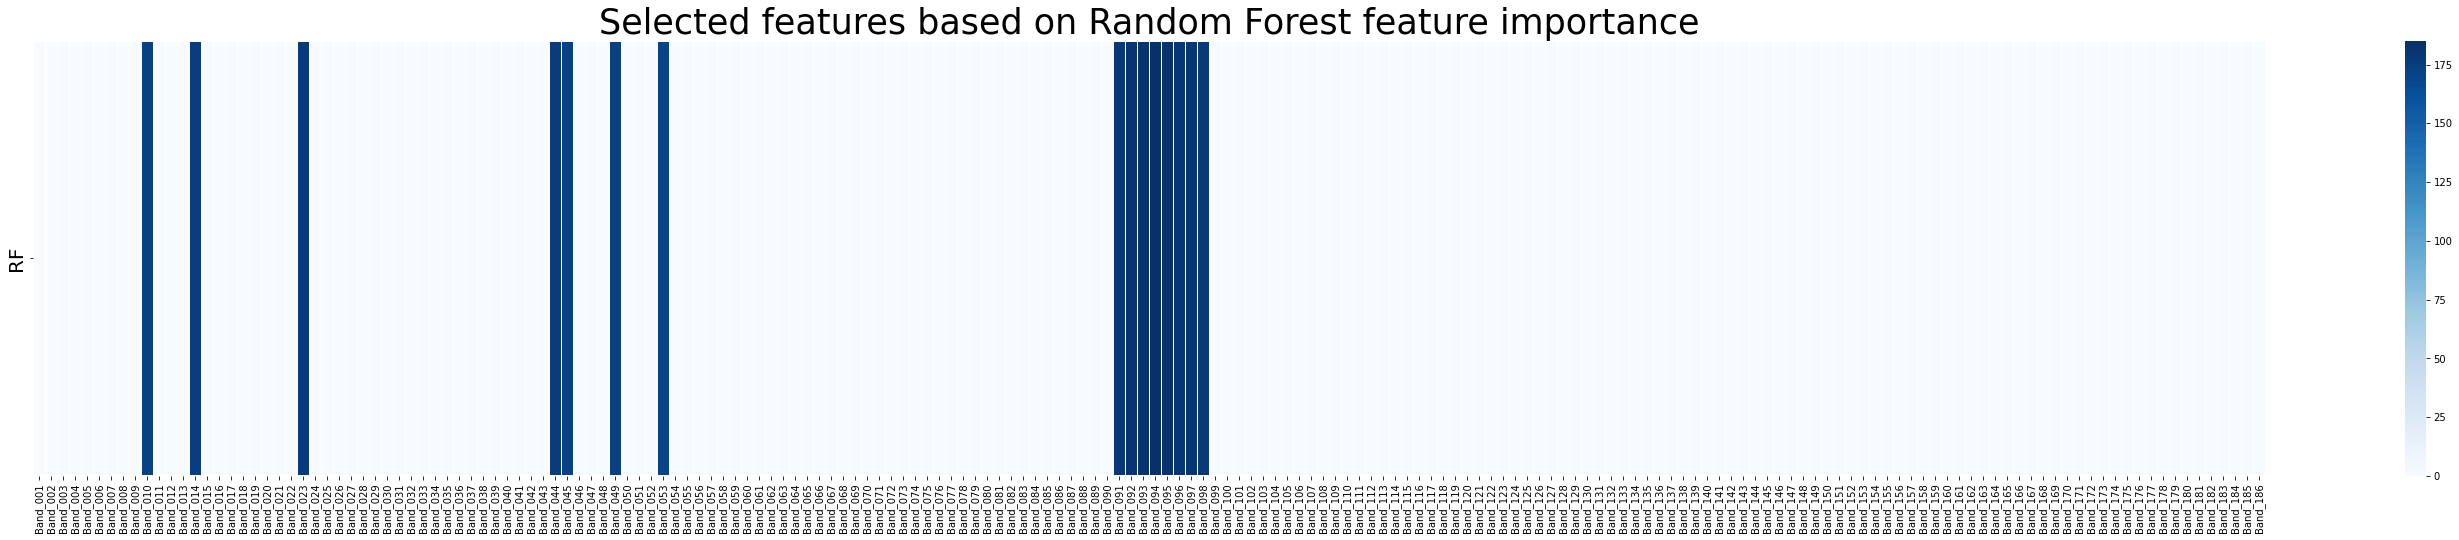

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,2:3].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[2:3], ax=ax)
plt.title('Selected features based on Random Forest feature importance', fontsize=35)
plt.yticks(fontsize=20)

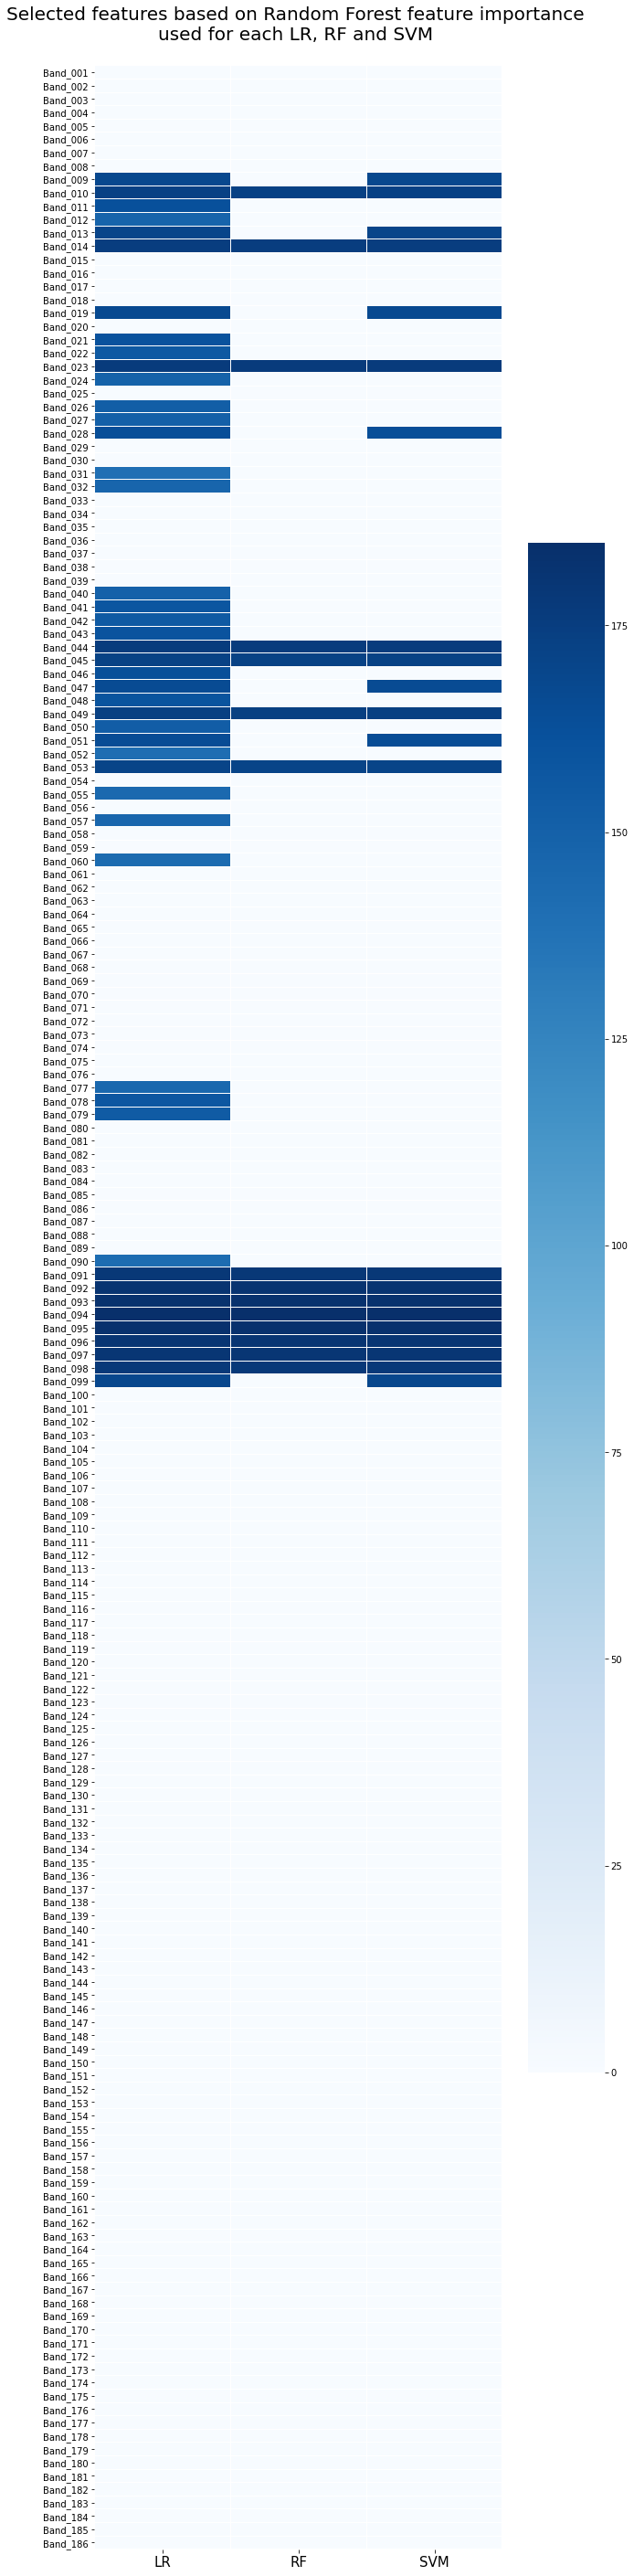

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features based on Random Forest feature importance \nused for each LR, RF and SVM \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)